In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.environments import WirelessCommunicationsEnv
from src.utils import Discretizer
from src.agents.dqn import DFHqn, Dqn
from src.agents.fhtlr import FHMaxTlr, FHTlr
from src.agents.ql import QLearning, FHQLearning
from src.agents.bf import Linear, FHLinear
from src.agents.rbf import RBF, FHRBF

import random
import numpy as np
import torch
from gymnasium import Env

* DQN and FHDQN without ER buffer work worse (buffer_size=1)
* DQN and FHDQN with lower LR work worse

# 1) Environment

In [2]:
GAMMA = 0.9
H = 5
C = 3

In [3]:
ENV = WirelessCommunicationsEnv(
    T=H,
    K=C,
    snr_max=8,
    snr_min=4,
    snr_autocorr=0.9,
    P_occ=np.array(
        [
            [0.5, 0.3],
            [0.5, 0.7],
        ]
    ),
    occ_initial=[1]*C,
    batt_harvest=2.0,
    P_harvest=0.5,
    batt_initial=10,
    batt_max_capacity=5,
    batt_weight=1.0,
    queue_initial=5,
    queue_weight=0.1,
    loss_busy=0.5,
)

In [4]:
DISCRETIZER = Discretizer(
    min_points_states=[0, 0, 0, 0, 0, 0, 0, 0],
    max_points_states=[10, 10, 10, 1, 1, 1, 10, 10],
    bucket_states=[10, 10, 10, 2, 2, 2, 10, 10],
    min_points_actions=[0, 0, 0],
    max_points_actions=[2, 2, 2],
    bucket_actions=[10, 10, 10],
)

# 2) Training

In [5]:
EPISODES = 50_000

In [6]:
def run_train_episode(env, agent, eps, eps_decay, H):
    s, _ = env.reset()
    for h in range(H):
        a = agent.select_action(s, h, eps)
        sp, r, d, _, _ = env.step(a)
        agent.buffer.append(h, s, a, sp, r, d)
        agent.update()

        if d:
            break

        s = sp
        eps *= eps_decay
    return eps

In [7]:
def run_test_episode(env, agent, H):
    G = 0
    s, _ = env.reset()
    for h in range(H):
        a = agent.select_greedy_action(s, h)
        s, r, d, _, _ = env.step(a)
        G += r

        if d:
            break
    return G

# 3) BASELINE

### 3.1) QL

In [8]:
ALPHA_QL = 10
BUFFER_SIZE = 1
SCALE_QL = 0.5

In [ ]:
eps_decay = 0.9999
Gs_fhql = []

for i in range(5):
    random.seed(i)
    np.random.seed(i)
    torch.manual_seed(i)
    Gs = []
    eps = 1.0
    fhql_lerner = FHQLearning(DISCRETIZER, ALPHA_QL, H,SCALE_QL, BUFFER_SIZE)
    for e in range(EPISODES):
        eps = run_train_episode(ENV, fhql_lerner, eps, eps_decay, H)
        if e % 10 == 0:
            G = run_test_episode(ENV, fhql_lerner, H)
            Gs.append(G)
            print(f"\rTrial: {i} - Episode: {e} - Return: {np.around(G, 2)} - Eps: {np.around(eps, 2)}", end="")
    Gs_fhql.append(Gs)
Gs_fhql = np.array(Gs_fhql)

In [ ]:
plt.plot(Gs_fhql.mean(axis=0))
# plt.plot(Gs_dqn[2])
plt.show()

### 3.2) LinearQL

In [22]:
ALPHA_Linear = 0.01
BUFFER_SIZE = 1_000

In [ ]:
eps_decay = 0.9999
Gs_linear = []

for i in range(5):
    random.seed(i)
    np.random.seed(i)
    torch.manual_seed(i)
    Gs = []
    eps = 1.0
    linear_learner = FHLinear(DISCRETIZER, ALPHA_Linear, H, BUFFER_SIZE)
    for e in range(EPISODES):
        eps = run_train_episode(ENV, linear_learner, eps, eps_decay, H)
        if e % 10 == 0:
            G = run_test_episode(ENV, linear_learner, H)
            Gs.append(G)
            print(f"\rTrial: {i} - Episode: {e} - Return: {np.around(G, 2)} - Eps: {np.around(eps, 2)}", end="")
    Gs_linear.append(Gs)
Gs_linear = np.array(Gs_linear)

In [ ]:
plt.plot(Gs_linear.mean(axis=0))
# plt.plot(Gs_dqn[2])
plt.show()

In [31]:
linear_learner = FHLinear(DISCRETIZER, ALPHA_Linear, H, BUFFER_SIZE)
s, _ = ENV.reset()
print(linear_learner.select_action(s, 0,0.01))
print(linear_learner.Q(s, 0).shape)

[0.         0.88888889 0.        ]
torch.Size([1000])


### 3.3) FHRBF

In [11]:
ALPHA_FHRBF = 0.01
BUFFER_SIZE = 1_000

In [17]:
eps_decay = 0.99998
Gs_FHRBF= []

for i in range(5):
    random.seed(i)
    np.random.seed(i)
    torch.manual_seed(i)
    Gs = []
    eps = 1.0
    fhrbf_learner = FHRBF(DISCRETIZER, ALPHA_FHRBF, H, BUFFER_SIZE)
    for e in range(EPISODES):
        eps = run_train_episode(ENV, fhrbf_learner, eps, eps_decay, H)
        if e % 10 == 0:
            G = run_test_episode(ENV, fhrbf_learner, H)
            Gs.append(G)
            print(f"\rTrial: {i} - Episode: {e} - Return: {np.around(G, 2)} - Eps: {np.around(eps, 2)}", end="")
    Gs_FHRBF.append(Gs)


Trial: 4 - Episode: 6420 - Return: 3.68 - Eps: 0.612

KeyboardInterrupt: 

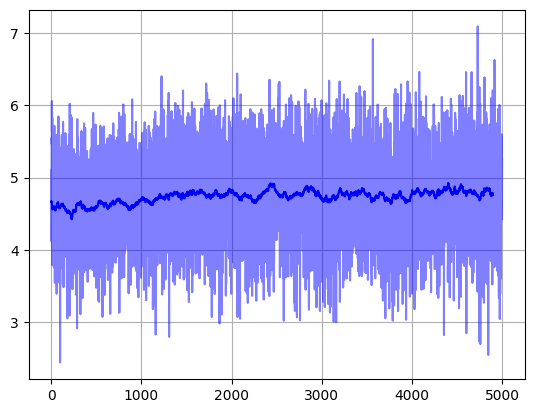

In [18]:
Gs_FHRBF = np.array(Gs_FHRBF)
w = 100
mean_fhrbf = Gs_FHRBF.mean(axis=0)
#mu_dqn_smt = [np.mean(mu_dqn[i - w : i]) for i in range(w, len(mu_dqn))]
mu_fhrbf_smt = [np.mean(mean_fhrbf[i - w : i]) for i in range(w, len(mean_fhrbf))]
plt.plot(mean_fhrbf, color="blue", alpha=0.5)
plt.plot(mu_fhrbf_smt, color="blue")
#plt.ylim(4.5, 5.5)
# plt.plot(Gs_dqn[2])
plt.grid()
plt.show()

In [10]:
fhrbf_learner = FHRBF(DISCRETIZER, ALPHA_FHRBF, H, BUFFER_SIZE)
fhrbf_learner.Q.num_rbf_features

10

# 4) DQN

In [8]:
ALPHA_DQN = 0.01
BUFFER_SIZE = 1_000

In [19]:
eps_decay = 0.9999
Gs_dqn = []

for i in range(5):
    random.seed(i)
    np.random.seed(i)
    torch.manual_seed(i)
    Gs = []
    eps = 1.0
    dqn_learner = Dqn(DISCRETIZER, ALPHA_DQN, H, BUFFER_SIZE)
    for e in range(EPISODES):
        eps = run_train_episode(ENV, dqn_learner, eps, eps_decay, H)
        if e % 10 == 0:
            G = run_test_episode(ENV, dqn_learner, H)
            Gs.append(G)
            print(f"\rTrial: {i} - Episode: {e} - Return: {np.around(G, 2)} - Eps: {np.around(eps, 2)}", end="")
    Gs_dqn.append(Gs)
Gs_dqn = np.array(Gs_dqn)

Trial: 4 - Episode: 19990 - Return: 3.76 - Eps: 0.01

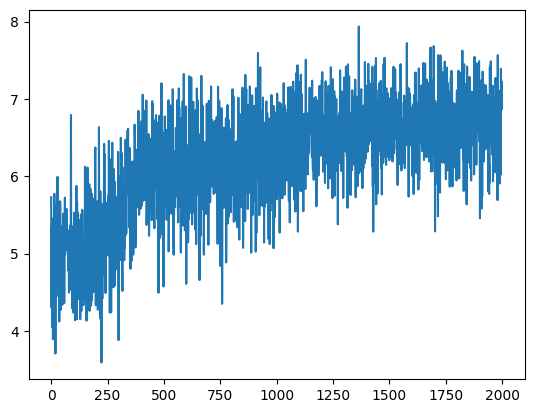

In [ ]:
plt.plot(Gs_dqn.mean(axis=0))
# plt.plot(Gs_dqn[2])
plt.show()

# 5) FH-DQN

In [18]:
ALPHA_DQN = 0.01
BUFFER_SIZE = 1_000

In [19]:
eps_decay = 0.9999
Gs_fhdqn = []

for i in range(100):
    Gs = []
    eps = 1.0
    dfhqn_learner = DFHqn(DISCRETIZER, ALPHA_DQN, H, BUFFER_SIZE)
    for e in range(EPISODES):
        eps = run_train_episode(ENV, dfhqn_learner, eps, eps_decay, H)
        if e % 10 == 0:
            G = run_test_episode(ENV, dfhqn_learner, H)
            Gs.append(G)
            print(f"\rTrial: {i} - Episode: {e} - Return: {np.around(G, 2)} - Eps: {np.around(eps, 2)}", end="")
    Gs_fhdqn.append(Gs)
Gs_fhdqn = np.array(Gs_fhdqn)

Trial: 99 - Episode: 19990 - Return: 7.42 - Eps: 0.01

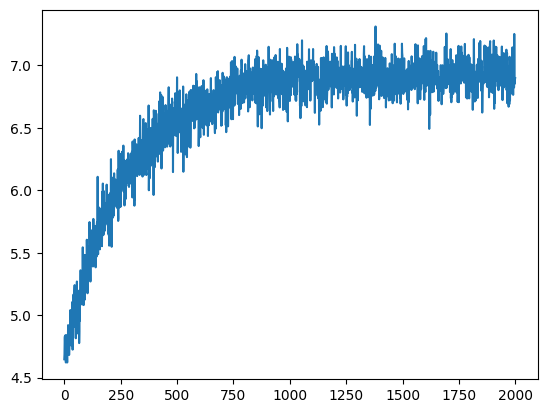

In [20]:
Gs_fhdqn = np.array(Gs_fhdqn)

plt.plot(Gs_fhdqn.mean(axis=0))
# plt.plot(Gs_fhdqn[2])
plt.show()

# 6) TLR

### 6.1) Max

In [8]:
ALPHA_FHTLR = 0.1
K = 20
SCALE = 0.5
W_DECAY = 0.0

In [92]:
eps_decay = 0.9999 # 0.99995 # 0.99999
Gs_fhtlr = []

for i in range(20):
    Gs = []
    eps = 1.0
    fhtlr_learner = FHMaxTlr(DISCRETIZER, ALPHA_FHTLR, H, K, SCALE, w_decay=W_DECAY)
    for e in range(EPISODES):
        eps = run_train_episode(ENV, fhtlr_learner, eps, eps_decay, H)
        if e % 10 == 0:
            G = run_test_episode(ENV, fhtlr_learner, H)
            Gs.append(G)
            print(f"\rTrial: {i} - Episode: {e} - Return: {np.around(G, 2)} - Eps: {np.around(eps, 2)}", end="")
    Gs_fhtlr.append(Gs)
Gs_fhtlr_ = np.array(Gs_fhtlr)

Trial: 19 - Episode: 19990 - Return: 6.96 - Eps: 0.01

In [93]:
Gs_fhtlr_ = np.array(Gs_fhtlr)

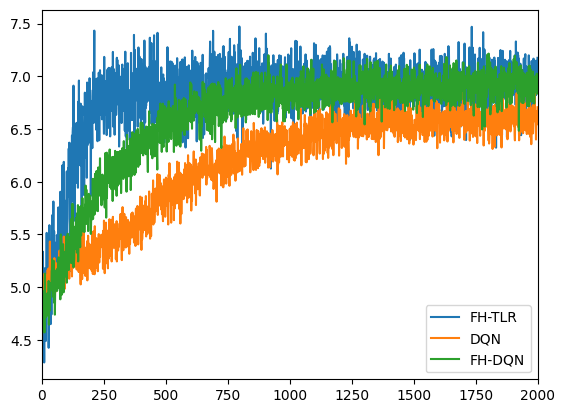

In [128]:
plt.plot(Gs_fhtlr_.mean(axis=0), label='FH-TLR')
plt.plot(Gs_dqn.mean(axis=0), label='DQN')
plt.plot(Gs_fhdqn.mean(axis=0), label='FH-DQN')
plt.xlim(0, 2_000)
plt.legend()
plt.show()

### 6.2) True

In [29]:
ALPHA_FHTLR = 0.1
K = 20
SCALE = 0.5
W_DECAY = 0.0

In [30]:
eps_decay = 0.9999 # 0.99995 # 0.99999
Gs_fhtlr_true = []

for i in range(20):
    Gs = []
    eps = 1.0
    fhtlr_true_learner = FHTlr(DISCRETIZER, ALPHA_FHTLR, H, K, SCALE, w_decay=W_DECAY)
    for e in range(EPISODES):
        eps = run_train_episode(ENV, fhtlr_true_learner, eps, eps_decay, H)
        if e % 10 == 0:
            G = run_test_episode(ENV, fhtlr_true_learner, H)
            Gs.append(G)
            print(f"\rTrial: {i} - Episode: {e} - Return: {np.around(G, 2)} - Eps: {np.around(eps, 2)}", end="")
    Gs_fhtlr_true.append(Gs)
Gs_fhtlr_true = np.array(Gs_fhtlr_true)

Trial: 19 - Episode: 19990 - Return: 7.77 - Eps: 0.01

In [24]:
Gs_fhtlr_true = np.array(Gs_fhtlr_true)

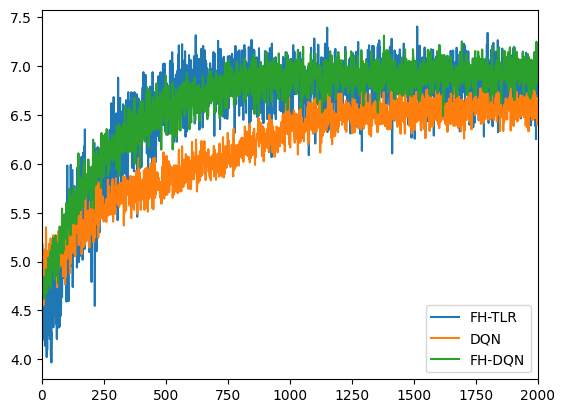

In [31]:
#plt.plot(Gs_fhtlr_.mean(axis=0), label='FH-Max-TLR')
plt.plot(Gs_fhtlr_true.mean(axis=0), label='FH-TLR')
plt.plot(Gs_dqn.mean(axis=0), label='DQN')
plt.plot(Gs_fhdqn.mean(axis=0), label='FH-DQN')
plt.xlim(0, 2_000)
plt.legend()
plt.show()

# 7) Test

In [96]:
def collect_trajectory(env, agent, H):
    states, actions = [], []
    s, _ = env.reset()
    states.append(s)
    for h in range(H):
        a = agent.select_greedy_action(s, h)
        s, _, d, _, _ = env.step(a)
        states.append(s), actions.append(a)

        if d:
            break
    states = np.array(states)
    actions = np.array(actions)
    return states, actions

### 7.1) DQN

In [115]:
states, actions = collect_trajectory(ENV, dqn_learner, H)

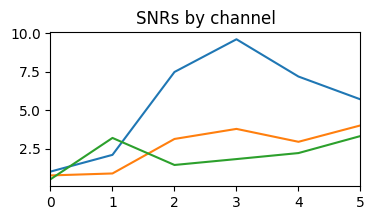

In [116]:
plt.figure(figsize=(4, 2))
plt.title("SNRs by channel")
plt.plot(states[:, 0])
plt.plot(states[:, 1])
plt.plot(states[:, 2])
plt.xlim(0, 5)
plt.show()

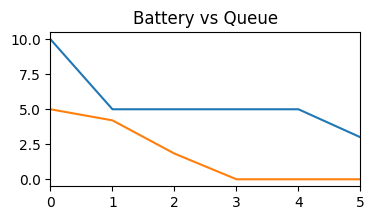

In [117]:
plt.figure(figsize=(4, 2))
plt.title("Battery vs Queue")
plt.plot(states[:, -1])
plt.plot(states[:, -2])
plt.xlim(0, 5)
plt.show()

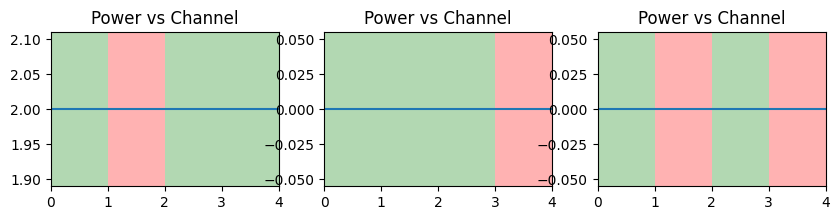

In [118]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
for j in range(C):
    axes[j].set_title("Power vs Channel")

    for i in range(len(states[:, 3]) - 1):
        color = 'green' if states[:, j + 3][i] == 0 else 'red'
        axes[j].axvspan(i - 1, i, facecolor=color, alpha=0.3)

    axes[j].plot(actions[:, j])
    axes[j].set_xlim(0, 4)
plt.show()

### 7.2) FH-DQN

In [119]:
states, actions = collect_trajectory(ENV, dfhqn_learner, H)

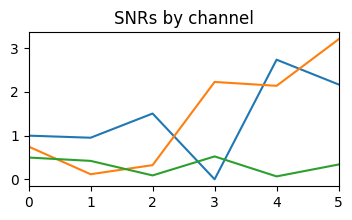

In [120]:
plt.figure(figsize=(4, 2))
plt.title("SNRs by channel")
plt.plot(states[:, 0])
plt.plot(states[:, 1])
plt.plot(states[:, 2])
plt.xlim(0, 5)
plt.show()

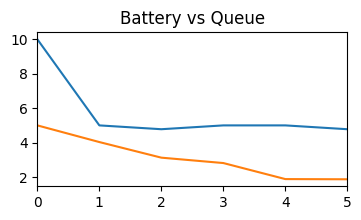

In [121]:
plt.figure(figsize=(4, 2))
plt.title("Battery vs Queue")
plt.plot(states[:, -1])
plt.plot(states[:, -2])
plt.xlim(0, 5)
plt.show()

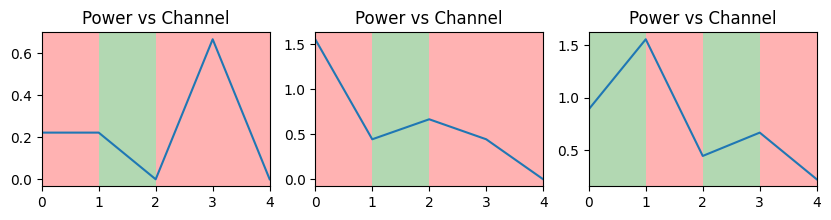

In [122]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
for j in range(C):
    axes[j].set_title("Power vs Channel")

    for i in range(len(states[:, 3]) - 1):
        color = 'green' if states[:, j + 3][i] == 0 else 'red'
        axes[j].axvspan(i - 1, i, facecolor=color, alpha=0.3)

    axes[j].plot(actions[:, j])
    axes[j].set_xlim(0, 4)
plt.show()

### 7.3) FH-TLR

In [123]:
states, actions = collect_trajectory(ENV, fhtlr_learner, H)

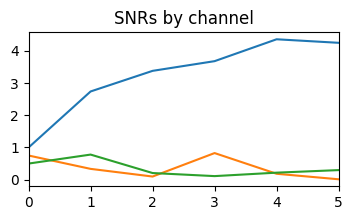

In [124]:
plt.figure(figsize=(4, 2))
plt.title("SNRs by channel")
plt.plot(states[:, 0])
plt.plot(states[:, 1])
plt.plot(states[:, 2])
plt.xlim(0, 5)
plt.show()

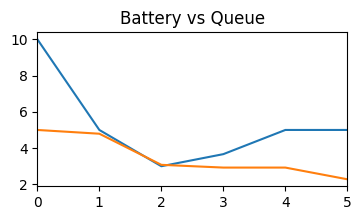

In [125]:
plt.figure(figsize=(4, 2))
plt.title("Battery vs Queue")
plt.plot(states[:, -1])
plt.plot(states[:, -2])
plt.xlim(0, 5)
plt.show()

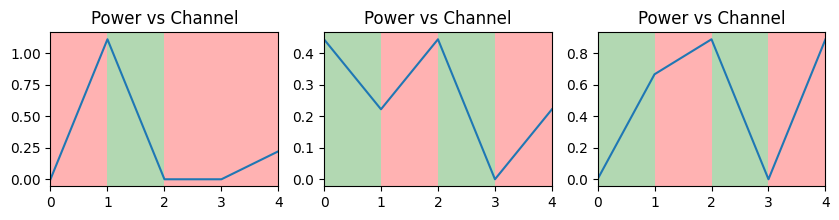

In [126]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
for j in range(C):
    axes[j].set_title("Power vs Channel")

    for i in range(len(states[:, 3]) - 1):
        color = 'green' if states[:, j + 3][i] == 0 else 'red'
        axes[j].axvspan(i - 1, i, facecolor=color, alpha=0.3)

    axes[j].plot(actions[:, j])
    axes[j].set_xlim(0, 4)
plt.show()